# New Idea

1. Create a NN that looks like:

Input (600 pixels)  $\to$ Dense(600) $\to \cdots \to $ Dense(600) $\to$ Dense(6) \to sum of gaussians

2. Train it on input = noisy, output = truth wothout noise.

3. Then the last dense layer is giving you the params we are looking for...


### Notes:
1. First try it on a single gaussian
2. Then do a gaussian with cont
3. Then do two related gaussians...etc.

## Load stuff

In [62]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import h5py
import tqdm

from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model
from keras.models import Sequential
from keras.layers import Dense, Lambda
import keras
import keras.backend as K
from IPython.display import clear_output

class PlotLosses(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        
        self.fig = plt.figure()
        
        self.logs = []

    def on_epoch_end(self, epoch, logs={}):
        
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.i += 1
        
        clear_output(wait=True)
        plt.semilogy(self.x, self.losses, label="loss")
        plt.semilogy(self.x, self.val_losses, label="val_loss")
        plt.legend()
        plt.show();
        
plot_losses = PlotLosses()


width = 200
ws = np.linspace(-3,3,width)

## Generate super simple data...

In [2]:
N_train_001 = 80000
ys_train_001 = np.zeros((N_train_001,width))
for k in tqdm.tqdm(range(N_train_001)):
    ampl = np.random.rand()
    pos  = 0 #np.random.rand()-0.5 
    ys_train_001[k] = ampl*np.exp(-(ws-pos)**2)

N_test_001 = 20000
ys_test_001 = np.zeros((N_test_001,width))
amp_test_001 = np.zeros(N_test_001)
pos_test_001 = np.zeros(N_test_001)
for k in tqdm.tqdm(range(N_test_001)):
    ampl = np.random.rand()
    pos  = 0 #np.random.rand()-0.5 
    amp_test_001[k] = ampl
    pos_test_001[k] = pos
    ys_test_001[k] = ampl*np.exp(-(ws-pos)**2)

100%|██████████| 20000/20000 [00:00<00:00, 127714.70it/s]


In [3]:
N_train_002 = 80000
ys_train_002 = np.zeros((N_train_002,width))
for k in tqdm.tqdm(range(N_train_002)):
    ampl = np.random.rand()
    pos  = 2.0*(np.random.rand()-0.5) 
    ys_train_002[k] = ampl*np.exp(-(ws-pos)**2)
    
N_test_002 = 20000
ys_test_002 = np.zeros((N_test_002,width))
amp_test_002 = np.zeros(N_test_002)
pos_test_002 = np.zeros(N_test_002)
for k in tqdm.tqdm(range(N_test_002)):
    ampl = np.random.rand()
    pos  = 2.0*(np.random.rand()-0.5) 
    amp_test_002[k] = ampl
    pos_test_002[k] = pos
    ys_test_002[k] = ampl*np.exp(-(ws-pos)**2)

100%|██████████| 20000/20000 [00:00<00:00, 130175.42it/s]


In [112]:
noiseminlevel = 0.05
noisemaxlevel = 0.33
widthmin = 0.2
widthmax = 1.5

N_train_003 = 80000
ys_train_003 = np.zeros((N_train_003,width))
ys_train_clean_003 = np.zeros((N_train_003,width))
shift_train_003 = np.zeros(N_train_003)
scale_train_003 = np.zeros(N_train_003)
for k in tqdm.tqdm(range(N_train_003)):
    ampl = np.random.rand()
    noiselevel = np.random.uniform(noiseminlevel,noisemaxlevel)
    width0 = np.random.uniform(widthmin,widthmax)
    pos  = 2.0*(np.random.rand()-0.5)
    noise = np.random.normal(0,ampl*noiselevel,width)
    puresignal = ampl*np.exp(-(ws-pos)**2/width0**2)
    signal = puresignal+noise
    shift = np.min(signal)
    scale = np.sqrt(np.var(signal))
    shift_train_003[k] = shift
    scale_train_003[k] = scale
    ys_train_003[k] = (signal-shift)/scale
    ys_train_clean_003[k] = (puresignal-shift)/scale
    
N_test_003 = 20000
ys_test_003 = np.zeros((N_test_003,width))
ys_test_clean_003 = np.zeros((N_test_003,width))
amp_test_003 = np.zeros(N_test_003)
pos_test_003 = np.zeros(N_test_003)
wid_test_003 = np.zeros(N_test_003)
shift_test_003 = np.zeros(N_test_003)
scale_test_003 = np.zeros(N_test_003)
for k in tqdm.tqdm(range(N_test_003)):
    ampl = np.random.rand()
    pos  = 2.0*(np.random.rand()-0.5) 
    noiselevel = np.random.uniform(noiseminlevel,noisemaxlevel)
    width0 = np.random.uniform(widthmin,widthmax)
    amp_test_003[k] = ampl
    pos_test_003[k] = pos
    wid_test_003[k] = width0
    noise = np.random.normal(0,ampl*noiselevel,width)
    puresignal = ampl*np.exp(-(ws-pos)**2/width0**2)
    signal = puresignal+noise
    shift = np.min(signal)
    scale = np.sqrt(np.var(signal))
    shift_test_003[k] = shift
    scale_test_003[k] = scale
    ys_test_003[k] = (signal-shift)/scale
    ys_test_clean_003[k] = (puresignal-shift)/scale

100%|██████████| 20000/20000 [00:01<00:00, 14930.97it/s]


In [226]:
noiseminlevel1 = 0.005
noisemaxlevel1 = 0.010

noiseminlevel2 = 0.05
noisemaxlevel2 = 0.1

noiseminlevel3 = 0.1
noisemaxlevel3 = 0.2

noiseminlevel4 = 0.2
noisemaxlevel4 = 0.33

widthmin = 0.1
widthmax = 0.2

N_train_004 = 80000
N_test_004 = 20000

ys_train_004_nl1 = np.zeros((N_train_004,width))
ys_train_clean_004_nl1 = np.zeros((N_train_004,width))
shift_train_004_nl1 = np.zeros(N_train_004)
scale_train_004_nl1 = np.zeros(N_train_004)
for k in tqdm.tqdm(range(N_train_004)):
    ampl = np.random.rand()
    amplside = np.random.uniform(0.1,1.0)
    noiselevel = np.random.uniform(noiseminlevel1,noisemaxlevel1)
    width0 = np.random.uniform(widthmin,widthmax)
    pos  = 2.0*(np.random.rand()-0.5)
    noise = np.random.normal(0,ampl*noiselevel,width)
    puresignal = ampl*np.exp(-(ws-pos)**2/width0**2)
    puresignal = puresignal + amplside*ampl*np.exp(-(ws-pos-0.8)**2/(width0)**2)
    puresignal = puresignal + (amplside/3)*ampl*np.exp(-(ws-pos-1.2)**2/(width0)**2)
    signal = puresignal+noise
    shift = np.min(signal)
    scale = np.sqrt(np.var(signal))
    shift_train_004_nl1[k] = shift
    scale_train_004_nl1[k] = scale
    ys_train_004_nl1[k] = (signal-shift)/scale
    ys_train_clean_004_nl1[k] = (puresignal-shift)/scale

ys_test_004_nl1 = np.zeros((N_test_004,width))
ys_test_clean_004_nl1 = np.zeros((N_test_004,width))
amp_test_004_nl1 = np.zeros(N_test_004)
ampside_test_004_nl1 = np.zeros(N_test_004)
pos_test_004_nl1 = np.zeros(N_test_004)
wid_test_004_nl1 = np.zeros(N_test_004)
shift_test_004_nl1 = np.zeros(N_test_004)
scale_test_004_nl1 = np.zeros(N_test_004)
for k in tqdm.tqdm(range(N_test_004)):
    ampl = np.random.rand()
    amplside = np.random.uniform(0.1,1.0)
    pos  = 2.0*(np.random.rand()-0.5) 
    noiselevel = np.random.uniform(noiseminlevel1,noisemaxlevel1)
    width0 = np.random.uniform(widthmin,widthmax)
    ampside_test_004_nl1[k] = amplside*ampl
    amp_test_004_nl1[k] = ampl
    pos_test_004_nl1[k] = pos
    wid_test_004_nl1[k] = width0
    noise = np.random.normal(0,ampl*noiselevel,width)
    puresignal = ampl*np.exp(-(ws-pos)**2/width0**2)
    puresignal = puresignal + amplside*ampl*np.exp(-(ws-pos-0.8)**2/(width0)**2)
    puresignal = puresignal + (amplside/3)*ampl*np.exp(-(ws-pos-1.2)**2/(width0)**2)
    signal = puresignal+noise
    shift = np.min(signal)
    scale = np.sqrt(np.var(signal))
    shift_test_004_nl1[k] = shift
    scale_test_004_nl1[k] = scale
    ys_test_004_nl1[k] = (signal-shift)/scale
    ys_test_clean_004_nl1[k] = (puresignal-shift)/scale
    
ys_train_004_nl2 = np.zeros((N_train_004,width))
ys_train_clean_004_nl2 = np.zeros((N_train_004,width))
shift_train_004_nl2 = np.zeros(N_train_004)
scale_train_004_nl2 = np.zeros(N_train_004)
for k in tqdm.tqdm(range(N_train_004)):
    ampl = np.random.rand()
    amplside = np.random.uniform(0.1,1.0)
    noiselevel = np.random.uniform(noiseminlevel2,noisemaxlevel2)
    width0 = np.random.uniform(widthmin,widthmax)
    pos  = 2.0*(np.random.rand()-0.5)
    noise = np.random.normal(0,ampl*noiselevel,width)
    puresignal = ampl*np.exp(-(ws-pos)**2/width0**2)
    puresignal = puresignal + amplside*ampl*np.exp(-(ws-pos-0.8)**2/(width0)**2)
    puresignal = puresignal + (amplside/3)*ampl*np.exp(-(ws-pos-1.2)**2/(width0)**2)
    signal = puresignal+noise
    shift = np.min(signal)
    scale = np.sqrt(np.var(signal))
    shift_train_004_nl2[k] = shift
    scale_train_004_nl2[k] = scale
    ys_train_004_nl2[k] = (signal-shift)/scale
    ys_train_clean_004_nl2[k] = (puresignal-shift)/scale

ys_test_004_nl2 = np.zeros((N_test_004,width))
ys_test_clean_004_nl2 = np.zeros((N_test_004,width))
amp_test_004_nl2 = np.zeros(N_test_004)
ampside_test_004_nl2 = np.zeros(N_test_004)
pos_test_004_nl2 = np.zeros(N_test_004)
wid_test_004_nl2 = np.zeros(N_test_004)
shift_test_004_nl2 = np.zeros(N_test_004)
scale_test_004_nl2 = np.zeros(N_test_004)
for k in tqdm.tqdm(range(N_test_004)):
    ampl = np.random.rand()
    amplside = np.random.uniform(0.1,1.0)
    pos  = 2.0*(np.random.rand()-0.5) 
    noiselevel = np.random.uniform(noiseminlevel2,noisemaxlevel2)
    width0 = np.random.uniform(widthmin,widthmax)
    ampside_test_004_nl2[k] = amplside*ampl
    amp_test_004_nl2[k] = ampl
    pos_test_004_nl2[k] = pos
    wid_test_004_nl2[k] = width0
    noise = np.random.normal(0,ampl*noiselevel,width)
    puresignal = ampl*np.exp(-(ws-pos)**2/width0**2)
    puresignal = puresignal + amplside*ampl*np.exp(-(ws-pos-0.8)**2/(width0)**2)
    puresignal = puresignal + (amplside/3)*ampl*np.exp(-(ws-pos-1.2)**2/(width0)**2)
    signal = puresignal+noise
    shift = np.min(signal)
    scale = np.sqrt(np.var(signal))
    shift_test_004_nl2[k] = shift
    scale_test_004_nl2[k] = scale
    ys_test_004_nl2[k] = (signal-shift)/scale
    ys_test_clean_004_nl2[k] = (puresignal-shift)/scale
    
ys_train_004_nl3 = np.zeros((N_train_004,width))
ys_train_clean_004_nl3 = np.zeros((N_train_004,width))
shift_train_004_nl3 = np.zeros(N_train_004)
scale_train_004_nl3 = np.zeros(N_train_004)
for k in tqdm.tqdm(range(N_train_004)):
    ampl = np.random.rand()
    amplside = np.random.uniform(0.1,1.0)
    noiselevel = np.random.uniform(noiseminlevel3,noisemaxlevel3)
    width0 = np.random.uniform(widthmin,widthmax)
    pos  = 2.0*(np.random.rand()-0.5)
    noise = np.random.normal(0,ampl*noiselevel,width)
    puresignal = ampl*np.exp(-(ws-pos)**2/width0**2)
    puresignal = puresignal + amplside*ampl*np.exp(-(ws-pos-0.8)**2/(width0)**2)
    puresignal = puresignal + (amplside/3)*ampl*np.exp(-(ws-pos-1.2)**2/(width0)**2)
    signal = puresignal+noise
    shift = np.min(signal)
    scale = np.sqrt(np.var(signal))
    shift_train_004_nl3[k] = shift
    scale_train_004_nl3[k] = scale
    ys_train_004_nl3[k] = (signal-shift)/scale
    ys_train_clean_004_nl3[k] = (puresignal-shift)/scale

ys_test_004_nl3 = np.zeros((N_test_004,width))
ys_test_clean_004_nl3 = np.zeros((N_test_004,width))
amp_test_004_nl3 = np.zeros(N_test_004)
ampside_test_004_nl3 = np.zeros(N_test_004)
pos_test_004_nl3 = np.zeros(N_test_004)
wid_test_004_nl3 = np.zeros(N_test_004)
shift_test_004_nl3 = np.zeros(N_test_004)
scale_test_004_nl3 = np.zeros(N_test_004)
for k in tqdm.tqdm(range(N_test_004)):
    ampl = np.random.rand()
    amplside = np.random.uniform(0.1,1.0)
    pos  = 2.0*(np.random.rand()-0.5) 
    noiselevel = np.random.uniform(noiseminlevel3,noisemaxlevel3)
    width0 = np.random.uniform(widthmin,widthmax)
    ampside_test_004_nl3[k] = amplside*ampl
    amp_test_004_nl3[k] = ampl
    pos_test_004_nl3[k] = pos
    wid_test_004_nl3[k] = width0
    noise = np.random.normal(0,ampl*noiselevel,width)
    puresignal = ampl*np.exp(-(ws-pos)**2/width0**2)
    puresignal = puresignal + amplside*ampl*np.exp(-(ws-pos-0.8)**2/(width0)**2)
    puresignal = puresignal + (amplside/3)*ampl*np.exp(-(ws-pos-1.2)**2/(width0)**2)
    signal = puresignal+noise
    shift = np.min(signal)
    scale = np.sqrt(np.var(signal))
    shift_test_004_nl3[k] = shift
    scale_test_004_nl3[k] = scale
    ys_test_004_nl3[k] = (signal-shift)/scale
    ys_test_clean_004_nl3[k] = (puresignal-shift)/scale

100%|██████████| 20000/20000 [00:04<00:00, 4994.65it/s]


In [227]:
ys_train_004_nl4 = np.zeros((N_train_004,width))
ys_train_clean_004_nl4 = np.zeros((N_train_004,width))
shift_train_004_nl4 = np.zeros(N_train_004)
scale_train_004_nl4 = np.zeros(N_train_004)
for k in tqdm.tqdm(range(N_train_004)):
    ampl = np.random.rand()
    amplside = np.random.uniform(0.1,1.0)
    noiselevel = np.random.uniform(noiseminlevel4,noisemaxlevel4)
    width0 = np.random.uniform(widthmin,widthmax)
    pos  = 2.0*(np.random.rand()-0.5)
    noise = np.random.normal(0,ampl*noiselevel,width)
    puresignal = ampl*np.exp(-(ws-pos)**2/width0**2)
    puresignal = puresignal + amplside*ampl*np.exp(-(ws-pos-0.8)**2/(width0)**2)
    puresignal = puresignal + (amplside/3)*ampl*np.exp(-(ws-pos-1.2)**2/(width0)**2)
    signal = puresignal+noise
    shift = np.min(signal)
    scale = np.sqrt(np.var(signal))
    shift_train_004_nl4[k] = shift
    scale_train_004_nl4[k] = scale
    ys_train_004_nl4[k] = (signal-shift)/scale
    ys_train_clean_004_nl4[k] = (puresignal-shift)/scale

ys_test_004_nl4 = np.zeros((N_test_004,width))
ys_test_clean_004_nl4 = np.zeros((N_test_004,width))
amp_test_004_nl4 = np.zeros(N_test_004)
ampside_test_004_nl4 = np.zeros(N_test_004)
pos_test_004_nl4 = np.zeros(N_test_004)
wid_test_004_nl4 = np.zeros(N_test_004)
shift_test_004_nl4 = np.zeros(N_test_004)
scale_test_004_nl4 = np.zeros(N_test_004)
for k in tqdm.tqdm(range(N_test_004)):
    ampl = np.random.rand()
    amplside = np.random.uniform(0.1,1.0)
    pos  = 2.0*(np.random.rand()-0.5) 
    noiselevel = np.random.uniform(noiseminlevel4,noisemaxlevel4)
    width0 = np.random.uniform(widthmin,widthmax)
    ampside_test_004_nl4[k] = amplside*ampl
    amp_test_004_nl4[k] = ampl
    pos_test_004_nl4[k] = pos
    wid_test_004_nl4[k] = width0
    noise = np.random.normal(0,ampl*noiselevel,width)
    puresignal = ampl*np.exp(-(ws-pos)**2/width0**2)
    puresignal = puresignal + amplside*ampl*np.exp(-(ws-pos-0.8)**2/(width0)**2)
    puresignal = puresignal + (amplside/3)*ampl*np.exp(-(ws-pos-1.2)**2/(width0)**2)
    signal = puresignal+noise
    shift = np.min(signal)
    scale = np.sqrt(np.var(signal))
    shift_test_004_nl4[k] = shift
    scale_test_004_nl4[k] = scale
    ys_test_004_nl4[k] = (signal-shift)/scale
    ys_test_clean_004_nl4[k] = (puresignal-shift)/scale

100%|██████████| 20000/20000 [00:01<00:00, 11731.22it/s]


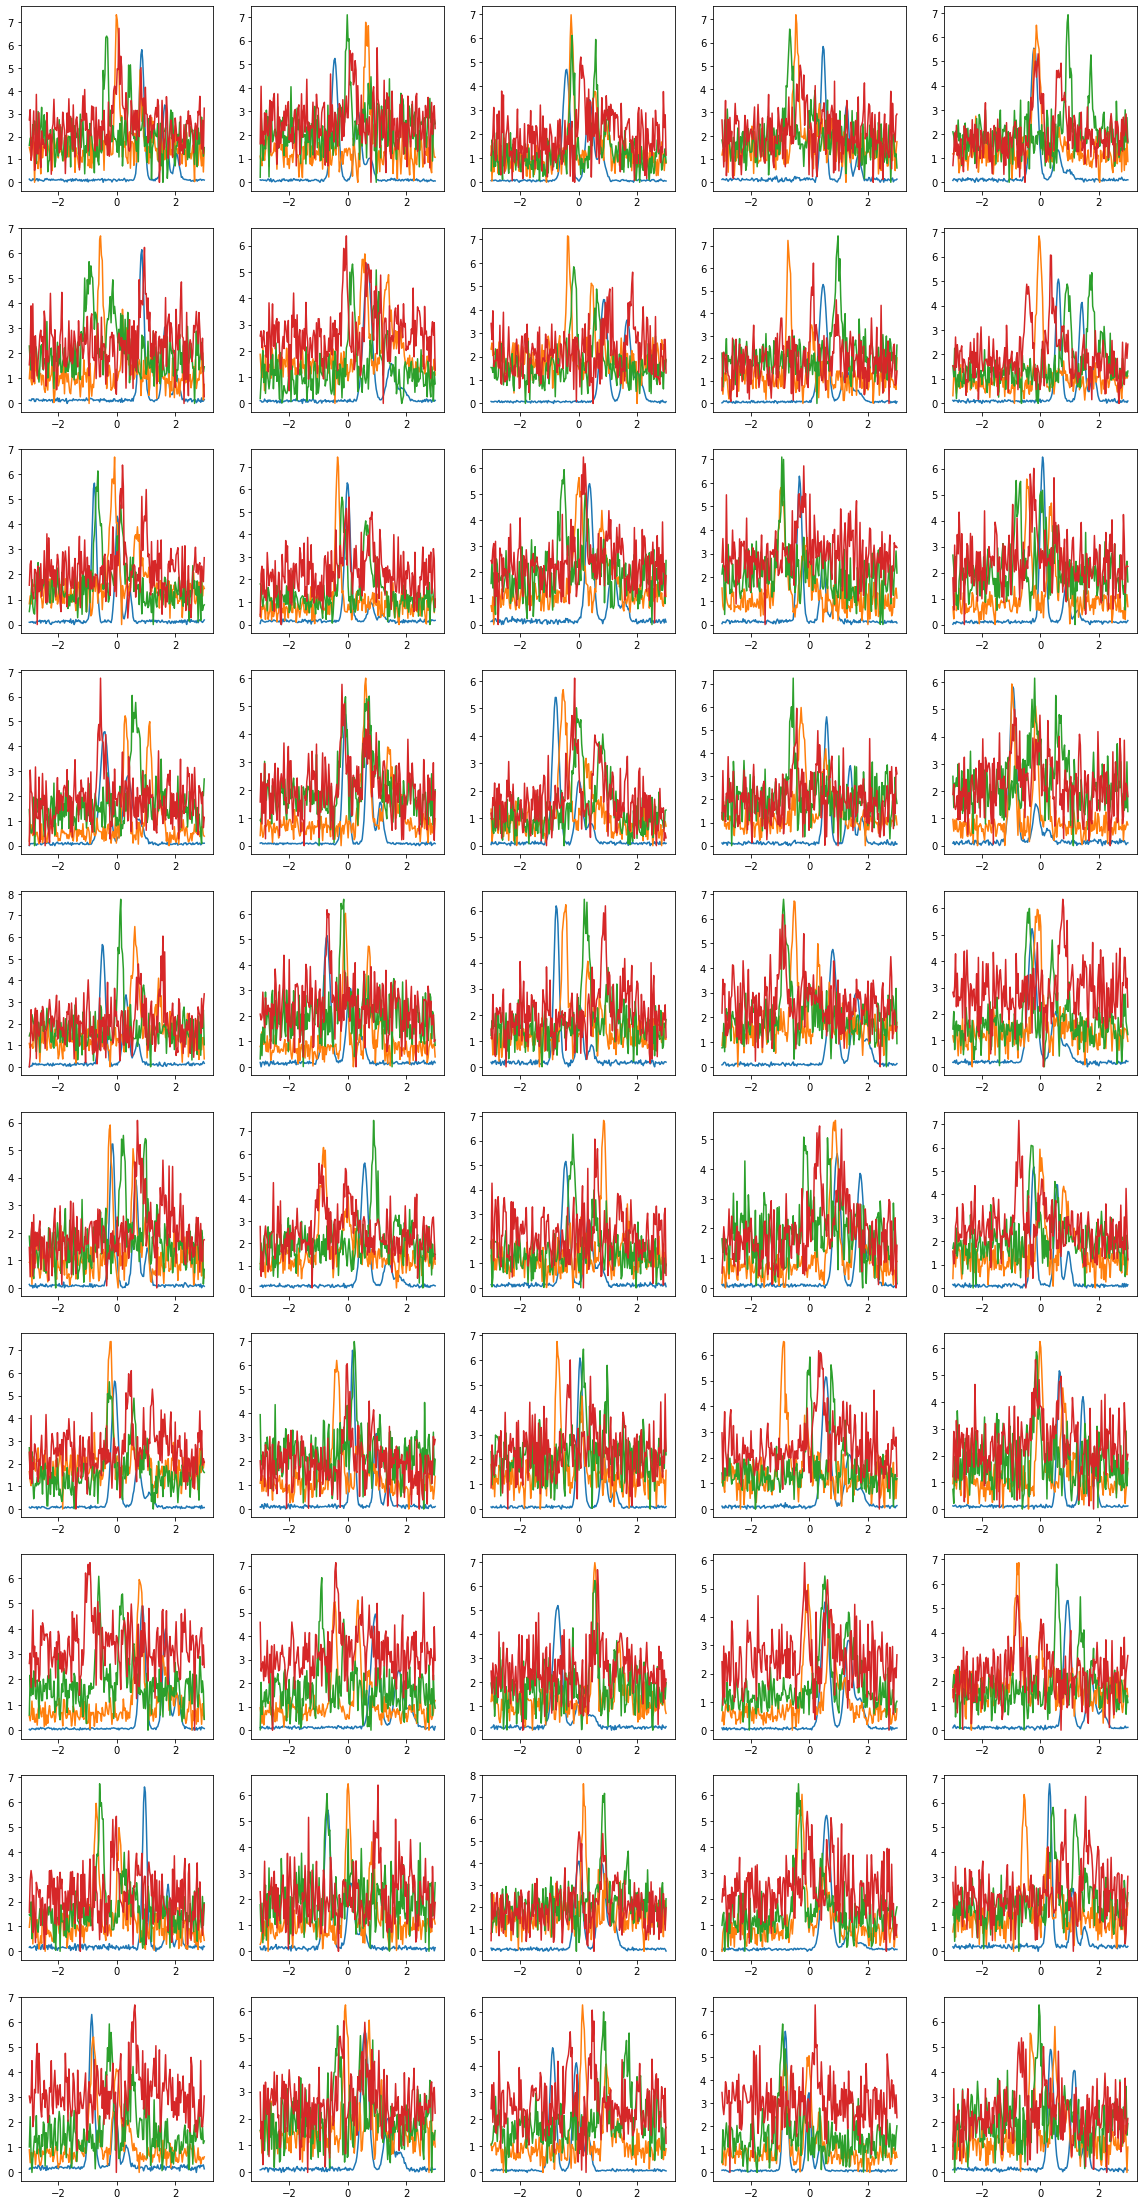

In [228]:
n1 = 5
n2 = 10
plt.figure(figsize=(4*n1,4*n2))
for i in range(n1*n2):
    plt.subplot(n2,n1,i+1)
    plt.plot(ws,ys_train_004_nl1[i],drawstyle='steps-mid',alpha=0.5)
    plt.plot(ws,ys_train_004_nl2[i],drawstyle='steps-mid',alpha=0.5)
    plt.plot(ws,ys_train_004_nl3[i],drawstyle='steps-mid',alpha=0.5)
    plt.plot(ws,ys_train_004_nl4[i],drawstyle='steps-mid',alpha=0.5)
plt.show()

In [114]:
def func_001(par):
    tfw = tf.cast(tf.linspace(-3,3, width),dtype=tf.float32)
    scale0 = par[:,0]
    tfwe = tf.expand_dims(tfw,axis=0)
    scalee = tf.expand_dims(scale0,axis=1)

    return scalee*tf.exp(-(tfwe)**2)

Model_001 = Sequential()
Model_001.add(Dense(200, input_dim=(width), activation='elu'))
Model_001.add(Dense(200, activation='relu'))
Model_001.add(Dense(20, activation='relu'))
Model_001.add(Dense(2,name='singleout'))
Model_001.add(Lambda(func_001))
#opt = keras.optimizers.Adam(learning_rate=0.01)
Model_001.compile( optimizer='adam', loss='mean_squared_error')

In [115]:
def func_002(par):
    tfw = tf.cast(tf.linspace(-3,3, width),dtype=tf.float32)
    scale0 = par[:,0]
    shift0 = par[:,1]
    tfwe = tf.expand_dims(tfw,axis=0)
    scale = tf.expand_dims(scale0,axis=1)
    shift = tf.expand_dims(shift0,axis=1)

    return scale*tf.exp(-(tfwe-shift)**2)

Model_002 = Sequential()
Model_002.add(Dense(200, input_dim=(width), activation='elu'))
Model_002.add(Dense(200, activation='relu'))
Model_002.add(Dense(200, activation='relu'))
Model_002.add(Dense(20, activation='relu'))
Model_002.add(Dense(2,name='singleout'))
Model_002.add(Lambda(func_002))
#opt = keras.optimizers.Adam(learning_rate=0.01)
Model_002.compile( optimizer='adam', loss='mean_squared_error')

In [116]:
def func_003(par):
    tfw = tf.cast(tf.linspace(-3,3, width),dtype=tf.float32)
    scale0 = par[:,0]
    shift0 = par[:,1]
    cont0  = par[:,2]
    wid0   = par[:,3]
    tfwe   = tf.expand_dims(tfw,axis=0)
    scale  = tf.expand_dims(scale0,axis=1)
    shift  = tf.expand_dims(shift0,axis=1)
    cont   = tf.expand_dims( cont0,axis=1)
    wid    = tf.expand_dims(  wid0,axis=1)
    
    return cont+scale*tf.exp(-(tfwe-shift)**2/wid**2)

tf.keras.backend.clear_session()
Model_003 = Sequential()
Model_003.add(Dense(200, input_dim=(width), activation='elu'))
Model_003.add(Dense(200, activation='relu'))
Model_003.add(Dense(200, activation='elu'))
Model_003.add(Dense(200, activation='relu'))
Model_003.add(Dense(20, activation='elu'))
Model_003.add(Dense(4,name='singleout'))
Model_003.add(Lambda(func_003))
#opt = keras.optimizers.Adam(learning_rate=0.01)
Model_003.compile( optimizer='adam', loss='mean_squared_error')

In [250]:
def func_004(par):
    tfw = tf.cast(tf.linspace(-3,3, width),dtype=tf.float32)
    scale0 = par[:,0]
    shift0 = par[:,1]
    cont0  = par[:,2]
    wid0   = par[:,3]
    amps0  = par[:,4]
    tfwe  = tf.expand_dims(tfw,axis=0)
    scale = tf.expand_dims(scale0,axis=1)
    shift = tf.expand_dims(shift0,axis=1)
    cont  = tf.expand_dims( cont0,axis=1)
    wid   = tf.expand_dims(  wid0,axis=1)
    amps  = tf.expand_dims( amps0,axis=1)
    ret = cont+scale*tf.exp(-(tfwe-shift)**2/wid**2)
    ret = ret + amps*scale*tf.exp(-(tfwe-shift-0.8)**2/(wid)**2)
    ret = ret + (amps/3)*scale*tf.exp(-(tfwe-shift-1.2)**2/(wid)**2)
    return ret

tf.keras.backend.clear_session()
Model_004_nl1 = Sequential()
Model_004_nl1.add(Dense(200, input_dim=(width), activation='elu'))
Model_004_nl1.add(Dense(200, activation='relu'))
Model_004_nl1.add(Dense(200, activation='elu'))
Model_004_nl1.add(Dense(200, activation='relu'))
Model_004_nl1.add(Dense(20, activation='elu'))
Model_004_nl1.add(Dense(5,name='singleout'))
Model_004_nl1.add(Lambda(func_004))
#opt = keras.optimizers.Adam(learning_rate=0.01)
Model_004_nl1.compile( optimizer='adam', loss='mean_squared_error')

In [251]:
Model_004_nl2 = Sequential()
Model_004_nl2.add(Dense(200, input_dim=(width), activation='elu'))
Model_004_nl2.add(Dense(200, activation='relu'))
Model_004_nl2.add(Dense(200, activation='elu'))
Model_004_nl2.add(Dense(200, activation='relu'))
Model_004_nl2.add(Dense(20, activation='elu'))
Model_004_nl2.add(Dense(5,name='singleout'))
Model_004_nl2.add(Lambda(func_004))
#opt = keras.optimizers.Adam(learning_rate=0.01)
Model_004_nl2.compile( optimizer='adam', loss='mean_squared_error')

In [252]:
Model_004_nl3 = Sequential()
Model_004_nl3.add(Dense(200, input_dim=(width), activation='elu'))
Model_004_nl3.add(Dense(200, activation='relu'))
Model_004_nl3.add(Dense(200, activation='elu'))
Model_004_nl3.add(Dense(200, activation='relu'))
Model_004_nl3.add(Dense(20, activation='elu'))
Model_004_nl3.add(Dense(5,name='singleout'))
Model_004_nl3.add(Lambda(func_004))
#opt = keras.optimizers.Adam(learning_rate=0.01)
Model_004_nl3.compile( optimizer='adam', loss='mean_squared_error')

In [267]:
Model_004_nl4 = Sequential()
Model_004_nl4.add(Dense(200, input_dim=(width), activation='elu'))
Model_004_nl4.add(Dense(200, activation='relu'))
Model_004_nl4.add(Dense(200, activation='elu'))
Model_004_nl4.add(Dense(200, activation='relu'))
Model_004_nl4.add(Dense(20, activation='elu'))
Model_004_nl4.add(Dense(5,name='singleout'))
Model_004_nl4.add(Lambda(func_004))
#opt = keras.optimizers.Adam(learning_rate=0.01)
Model_004_nl4.compile( optimizer='adam', loss='mean_squared_error')

In [268]:
layer_name = 'singleout'
Extractor_001 = keras.Model(inputs=Model_001.input,outputs=Model_001.get_layer(layer_name).output)

Extractor_002 = keras.Model(inputs=Model_002.input,outputs=Model_002.get_layer(layer_name).output)

Extractor_003 = keras.Model(inputs=Model_003.input,outputs=Model_003.get_layer(layer_name).output)


Extractor_004_nl1 = keras.Model(inputs=Model_004_nl1.input,outputs=Model_004_nl1.get_layer(layer_name).output)
Extractor_004_nl2 = keras.Model(inputs=Model_004_nl2.input,outputs=Model_004_nl2.get_layer(layer_name).output)
Extractor_004_nl3 = keras.Model(inputs=Model_004_nl3.input,outputs=Model_004_nl3.get_layer(layer_name).output)
Extractor_004_nl4 = keras.Model(inputs=Model_004_nl4.input,outputs=Model_004_nl4.get_layer(layer_name).output)

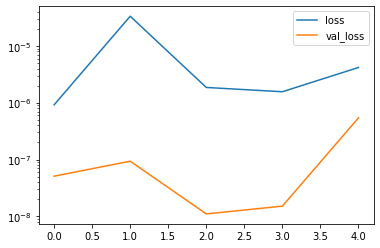

In [269]:
Model_001.fit(ys_train_001,ys_train_001,epochs=5,\
              validation_data=(ys_test_001, ys_test_001),callbacks=[plot_losses])

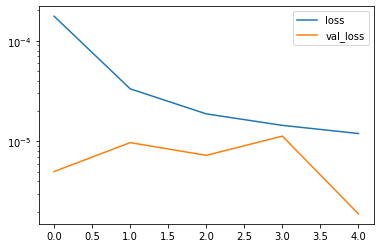

In [119]:
Model_002.fit(ys_train_002,ys_train_002,epochs=5,\
              validation_data=(ys_test_002, ys_test_002),callbacks=[plot_losses])

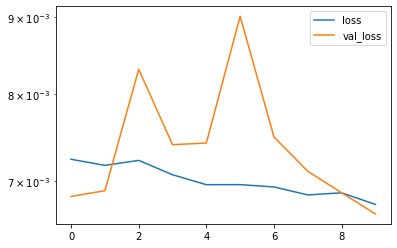

In [122]:
Model_003.fit(ys_train_003,ys_train_clean_003,epochs=10,\
              validation_data=(ys_test_003, ys_test_clean_003),callbacks=[plot_losses])

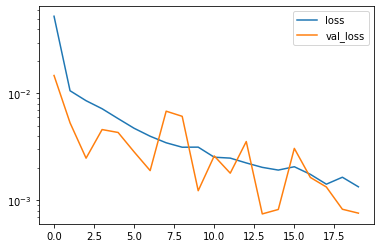

In [255]:
Model_004_nl1.fit(ys_train_004_nl1,ys_train_clean_004_nl1,epochs=20,\
              validation_data=(ys_test_004_nl1, ys_test_clean_004_nl1),callbacks=[plot_losses],shuffle=True)

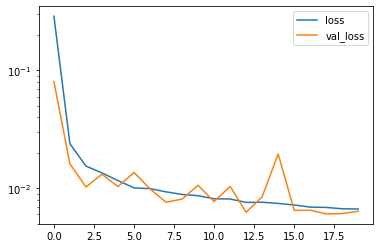

In [256]:
Model_004_nl2.fit(ys_train_004_nl2,ys_train_clean_004_nl2,epochs=20,\
              validation_data=(ys_test_004_nl2, ys_test_clean_004_nl2),callbacks=[plot_losses],shuffle=True)

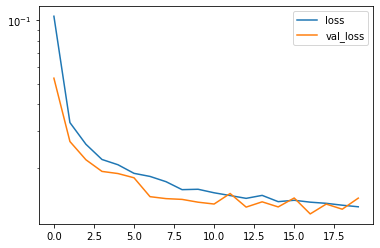

In [257]:
Model_004_nl3.fit(ys_train_004_nl3,ys_train_clean_004_nl3,epochs=20,\
              validation_data=(ys_test_004_nl3, ys_test_clean_004_nl3),callbacks=[plot_losses],shuffle=True)

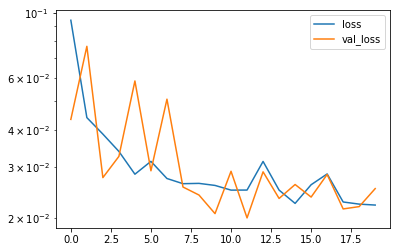

In [270]:
Model_004_nl4.fit(ys_train_004_nl4,ys_train_clean_004_nl4,epochs=20,\
              validation_data=(ys_test_004_nl4, ys_test_clean_004_nl4),callbacks=[plot_losses],shuffle=True,batch_size=8)

# Evaluate results

In [123]:
ampl_001_test_res = Extractor_001(ys_test_001).numpy()[:,0]

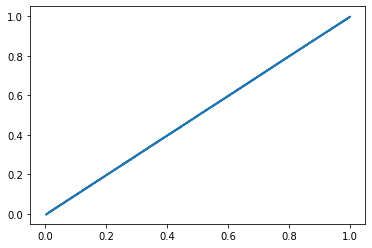

In [124]:
plt.scatter(amp_test_001,ampl_001_test_res,s=0.01)
plt.show()

In [125]:
ampl_002_test_res = Extractor_002(ys_test_002).numpy()[:,0]
shift_002_test_res = Extractor_002(ys_test_002).numpy()[:,1]

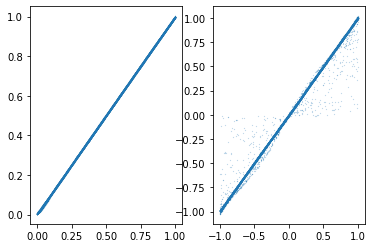

In [126]:
plt.subplot(1,2,1)
plt.scatter(amp_test_002,ampl_002_test_res,s=0.01)
plt.subplot(1,2,2)
plt.scatter(pos_test_002,shift_002_test_res,s=0.01)
plt.show()

In [199]:
ampl_003_test_res = Extractor_003(ys_test_003).numpy()[:,0]
pos_003_test_res = Extractor_003(ys_test_003).numpy()[:,1]
con_003_test_res = Extractor_003(ys_test_003).numpy()[:,2]
wid_003_test_res = Extractor_003(ys_test_003).numpy()[:,3]

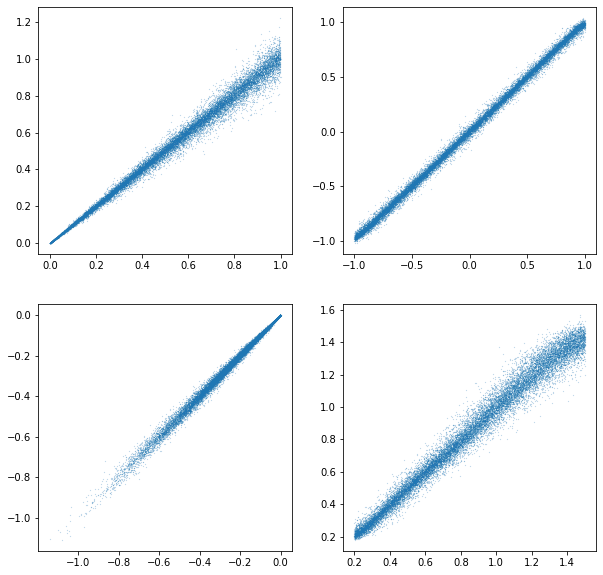

In [200]:
plt.figure(figsize=(10,10))
plt.subplot(2,2,1)
plt.scatter(amp_test_003,ampl_003_test_res*scale_test_003,s=0.01)
plt.subplot(2,2,2)
plt.scatter(pos_test_003,pos_003_test_res,s=0.01)
plt.subplot(2,2,3)
plt.scatter(shift_test_003,-con_003_test_res*scale_test_003,s=0.01)
plt.subplot(2,2,4)
plt.scatter(wid_test_003,wid_003_test_res,s=0.01)
plt.show()

In [271]:
ampl_004_nl1_test_res = Extractor_004_nl1(ys_test_004_nl1).numpy()[:,0]
pos_004_nl1_test_res = Extractor_004_nl1(ys_test_004_nl1).numpy()[:,1]
con_004_nl1_test_res = Extractor_004_nl1(ys_test_004_nl1).numpy()[:,2]
wid_004_nl1_test_res = Extractor_004_nl1(ys_test_004_nl1).numpy()[:,3]

ampl_004_nl2_test_res = Extractor_004_nl2(ys_test_004_nl2).numpy()[:,0]
pos_004_nl2_test_res = Extractor_004_nl2(ys_test_004_nl2).numpy()[:,1]
con_004_nl2_test_res = Extractor_004_nl2(ys_test_004_nl2).numpy()[:,2]
wid_004_nl2_test_res = Extractor_004_nl2(ys_test_004_nl2).numpy()[:,3]

ampl_004_nl3_test_res = Extractor_004_nl3(ys_test_004_nl3).numpy()[:,0]
pos_004_nl3_test_res = Extractor_004_nl3(ys_test_004_nl3).numpy()[:,1]
con_004_nl3_test_res = Extractor_004_nl3(ys_test_004_nl3).numpy()[:,2]
wid_004_nl3_test_res = Extractor_004_nl3(ys_test_004_nl3).numpy()[:,3]

ampl_004_nl4_test_res = Extractor_004_nl4(ys_test_004_nl4).numpy()[:,0]
pos_004_nl4_test_res = Extractor_004_nl4(ys_test_004_nl4).numpy()[:,1]
con_004_nl4_test_res = Extractor_004_nl4(ys_test_004_nl4).numpy()[:,2]
wid_004_nl4_test_res = Extractor_004_nl4(ys_test_004_nl4).numpy()[:,3]

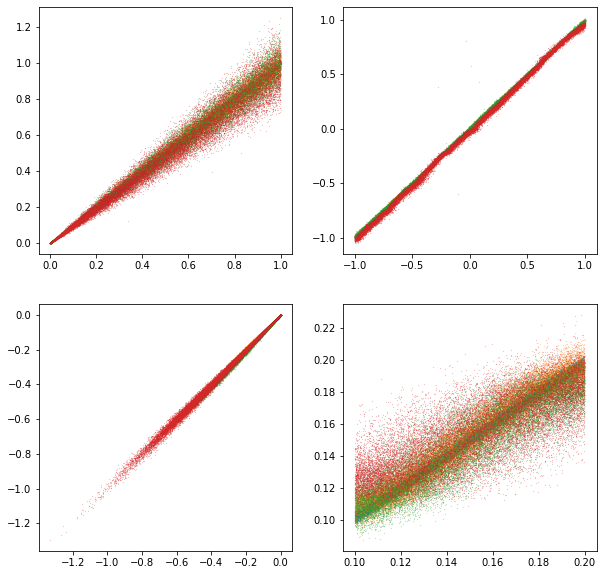

In [272]:
plt.figure(figsize=(10,10))
plt.subplot(2,2,1)
plt.scatter(amp_test_004_nl1,ampl_004_nl1_test_res*scale_test_004_nl1,s=0.01)
plt.scatter(amp_test_004_nl2,ampl_004_nl2_test_res*scale_test_004_nl2,s=0.01)
plt.scatter(amp_test_004_nl3,ampl_004_nl3_test_res*scale_test_004_nl3,s=0.01)
plt.scatter(amp_test_004_nl4,ampl_004_nl4_test_res*scale_test_004_nl4,s=0.01)
plt.subplot(2,2,2)
plt.scatter(pos_test_004_nl1,pos_004_nl1_test_res,s=0.01)
plt.scatter(pos_test_004_nl2,pos_004_nl2_test_res,s=0.01)
plt.scatter(pos_test_004_nl3,pos_004_nl3_test_res,s=0.01)
plt.scatter(pos_test_004_nl4,pos_004_nl4_test_res,s=0.01)
plt.subplot(2,2,3)
plt.scatter(shift_test_004_nl1,-con_004_nl1_test_res*scale_test_004_nl1,s=0.01)
plt.scatter(shift_test_004_nl2,-con_004_nl2_test_res*scale_test_004_nl2,s=0.01)
plt.scatter(shift_test_004_nl3,-con_004_nl3_test_res*scale_test_004_nl3,s=0.01)
plt.scatter(shift_test_004_nl4,-con_004_nl4_test_res*scale_test_004_nl4,s=0.01)
plt.subplot(2,2,4)
plt.scatter(wid_test_004_nl1,np.abs(wid_004_nl1_test_res),s=0.01)
plt.scatter(wid_test_004_nl2,np.abs(wid_004_nl2_test_res),s=0.01)
plt.scatter(wid_test_004_nl3,np.abs(wid_004_nl3_test_res),s=0.01)
plt.scatter(wid_test_004_nl4,np.abs(wid_004_nl4_test_res),s=0.01)
plt.show()

## Show some examples

In [273]:
pred_003 = Model_003.predict(ys_test_003)
pred_004_nl1 = Model_004_nl1.predict(ys_test_004_nl1)
pred_004_nl2 = Model_004_nl2.predict(ys_test_004_nl2)
pred_004_nl3 = Model_004_nl3.predict(ys_test_004_nl3)
pred_004_nl4 = Model_004_nl4.predict(ys_test_004_nl4)


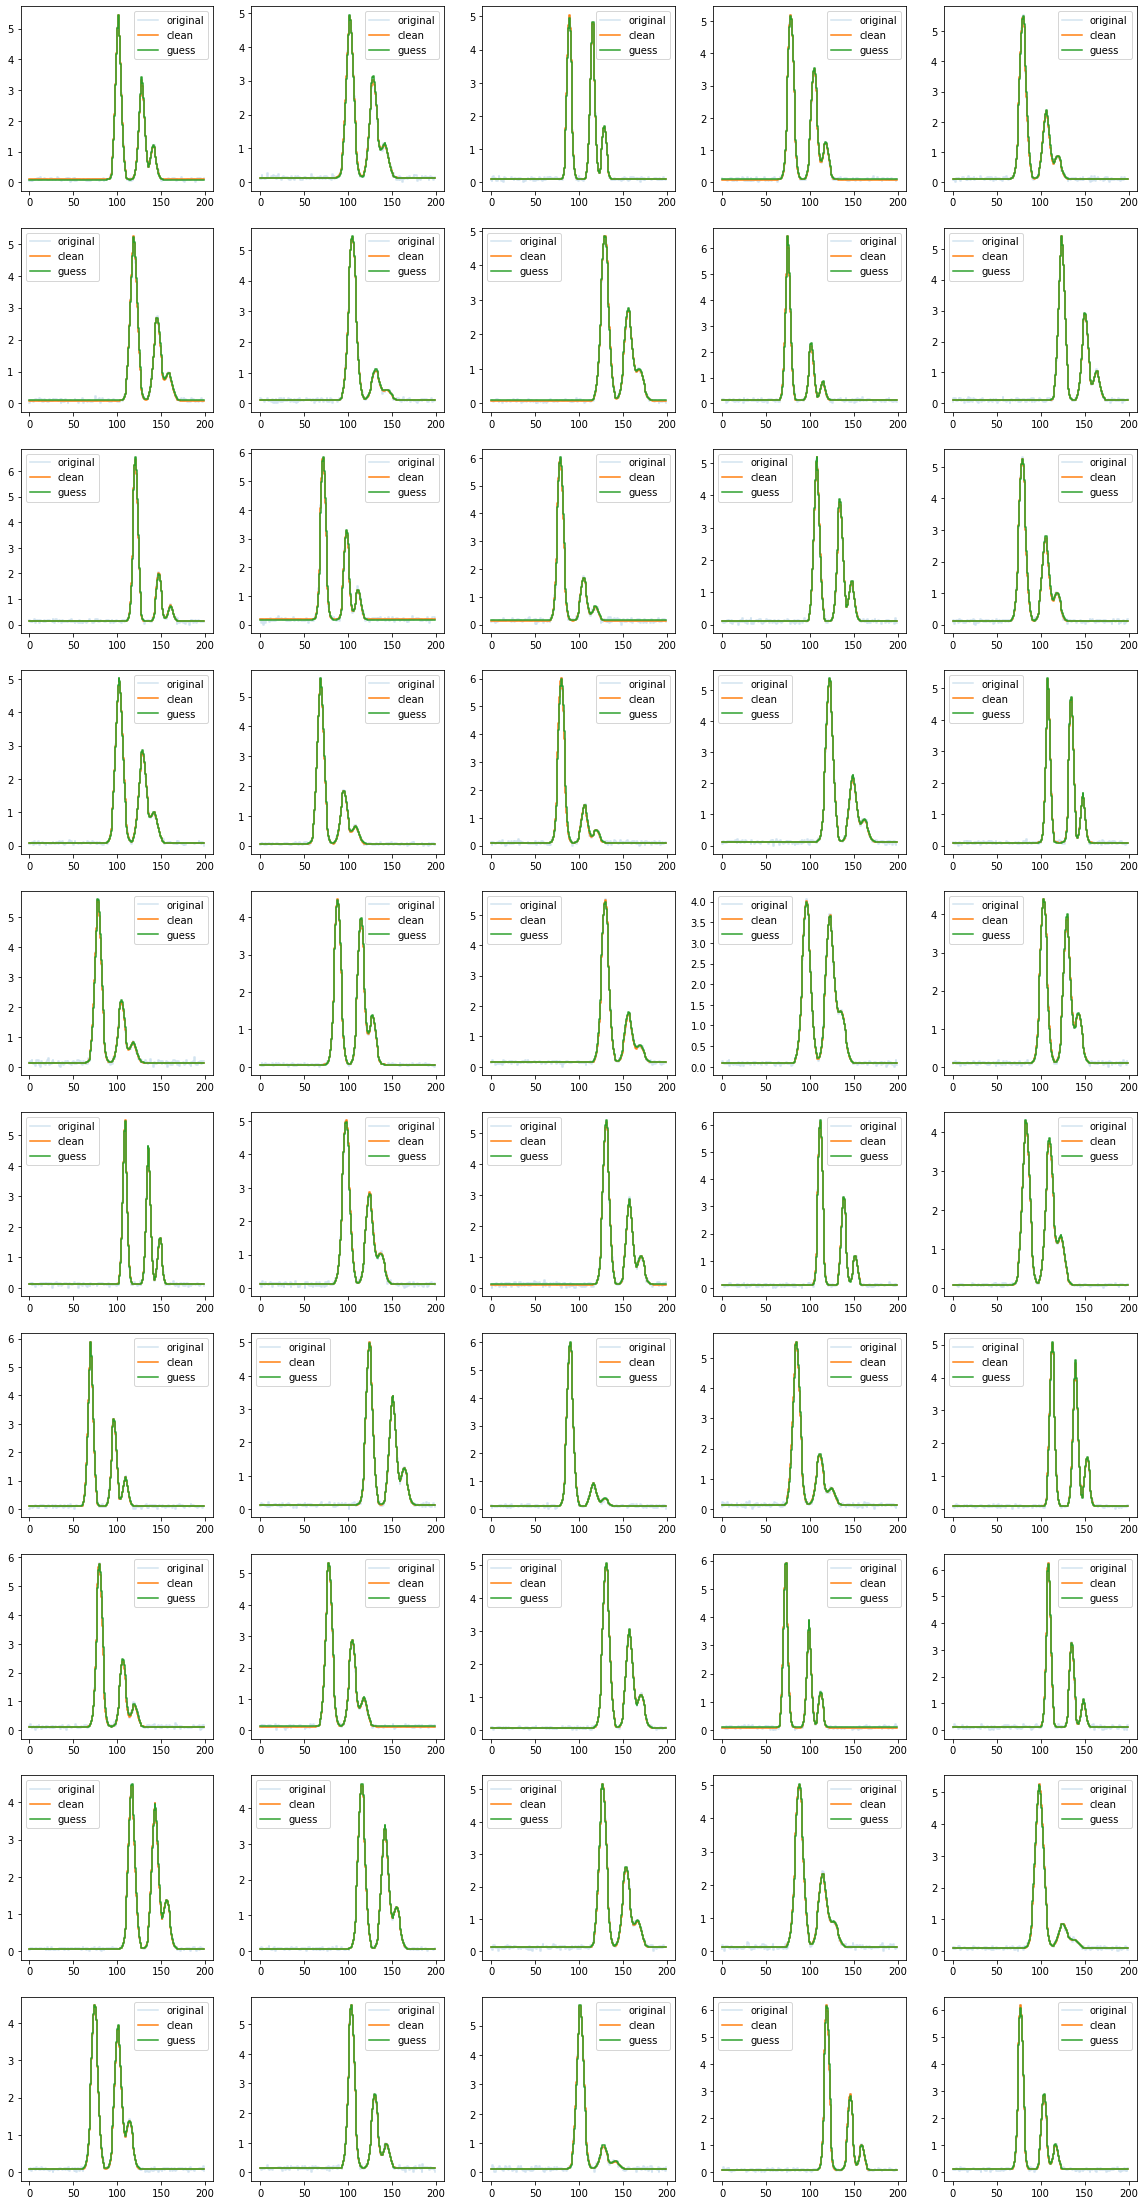

In [278]:
n1 = 5
n2 = 10
plt.figure(figsize=(4*n1,4*n2))
for i in range(n1*n2):
    plt.subplot(n2,n1,i+1)
    plt.plot(ys_test_004_nl1[i],label='original',alpha=0.2,drawstyle='steps-mid')
    plt.plot(ys_test_clean_004_nl1[i],label='clean',drawstyle='steps-mid')
    plt.plot(pred_004_nl1[i],label='guess',drawstyle='steps-mid')
    plt.legend()
plt.show()

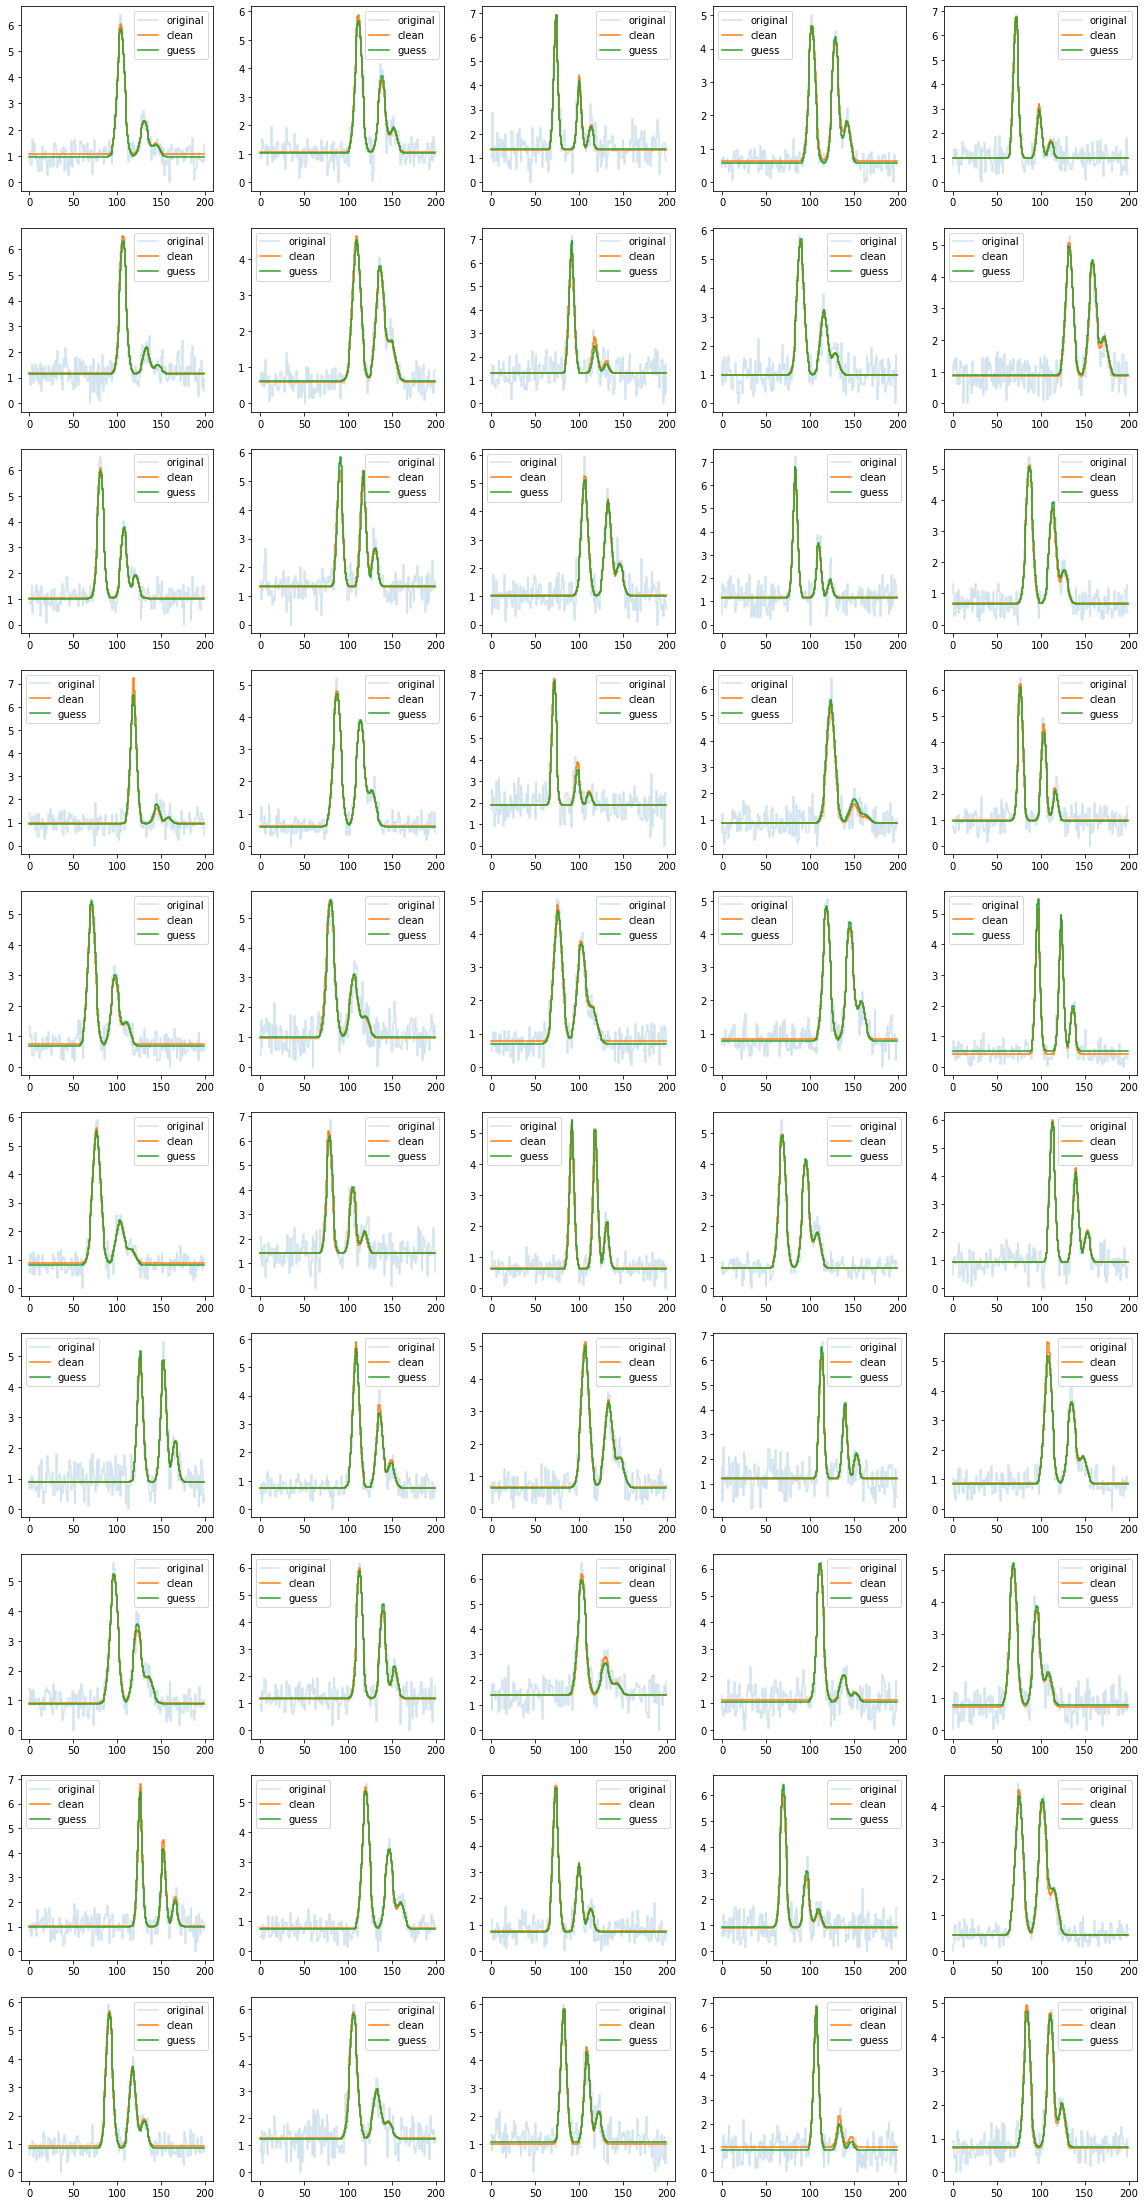

In [279]:
n1 = 5
n2 = 10
plt.figure(figsize=(4*n1,4*n2))
for i in range(n1*n2):
    plt.subplot(n2,n1,i+1)
    plt.plot(ys_test_004_nl2[i],label='original',alpha=0.2,drawstyle='steps-mid')
    plt.plot(ys_test_clean_004_nl2[i],label='clean',drawstyle='steps-mid')
    plt.plot(pred_004_nl2[i],label='guess',drawstyle='steps-mid')
    plt.legend()
plt.show()

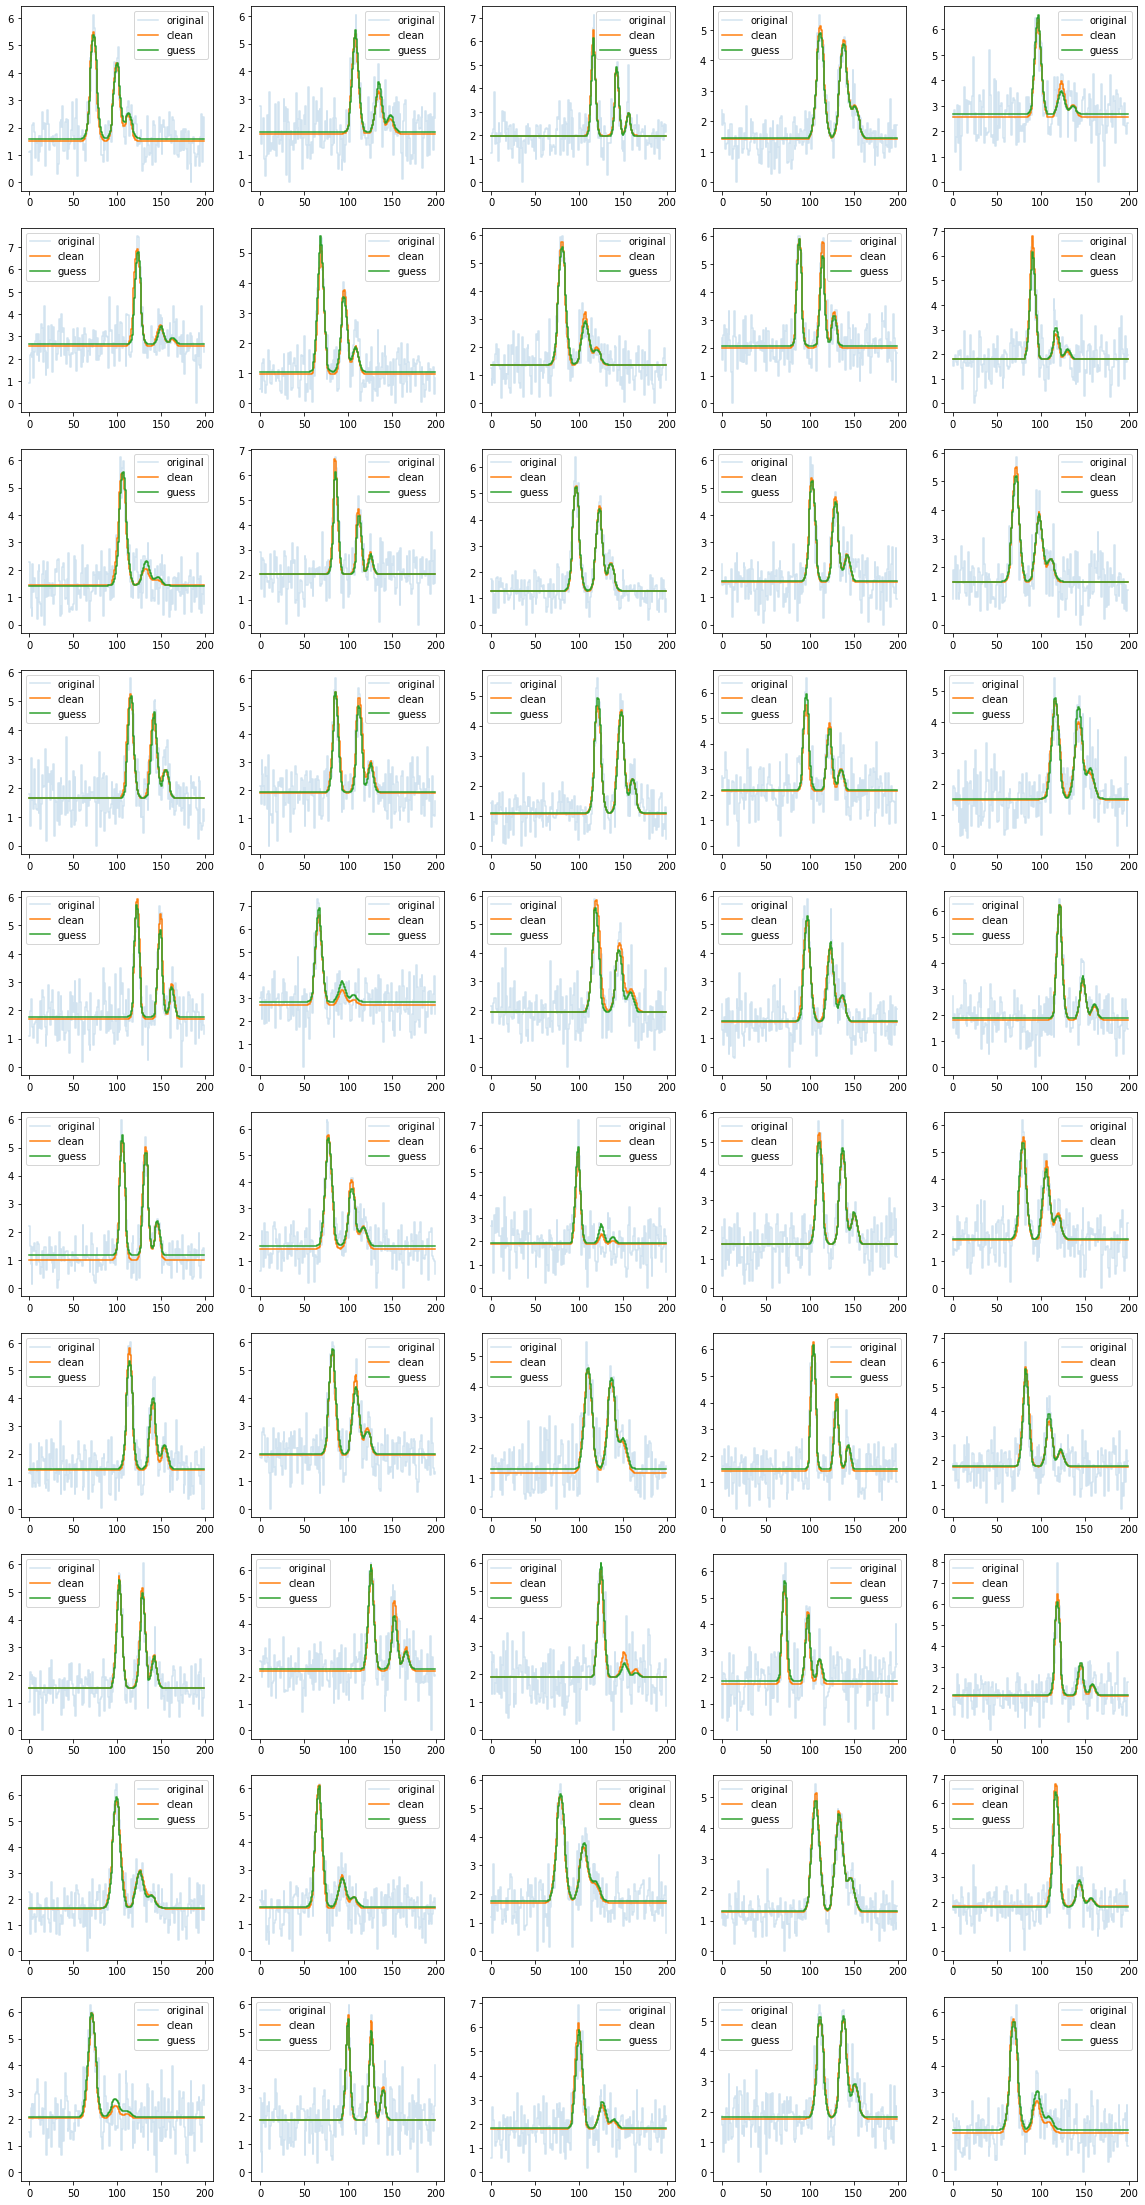

In [276]:
n1 = 5
n2 = 10
plt.figure(figsize=(4*n1,4*n2))
for i in range(n1*n2):
    plt.subplot(n2,n1,i+1)
    plt.plot(ys_test_004_nl3[i],label='original',alpha=0.2,drawstyle='steps-mid')
    plt.plot(ys_test_clean_004_nl3[i],label='clean',drawstyle='steps-mid')
    plt.plot(pred_004_nl3[i],label='guess',drawstyle='steps-mid')
    plt.legend()
plt.show()

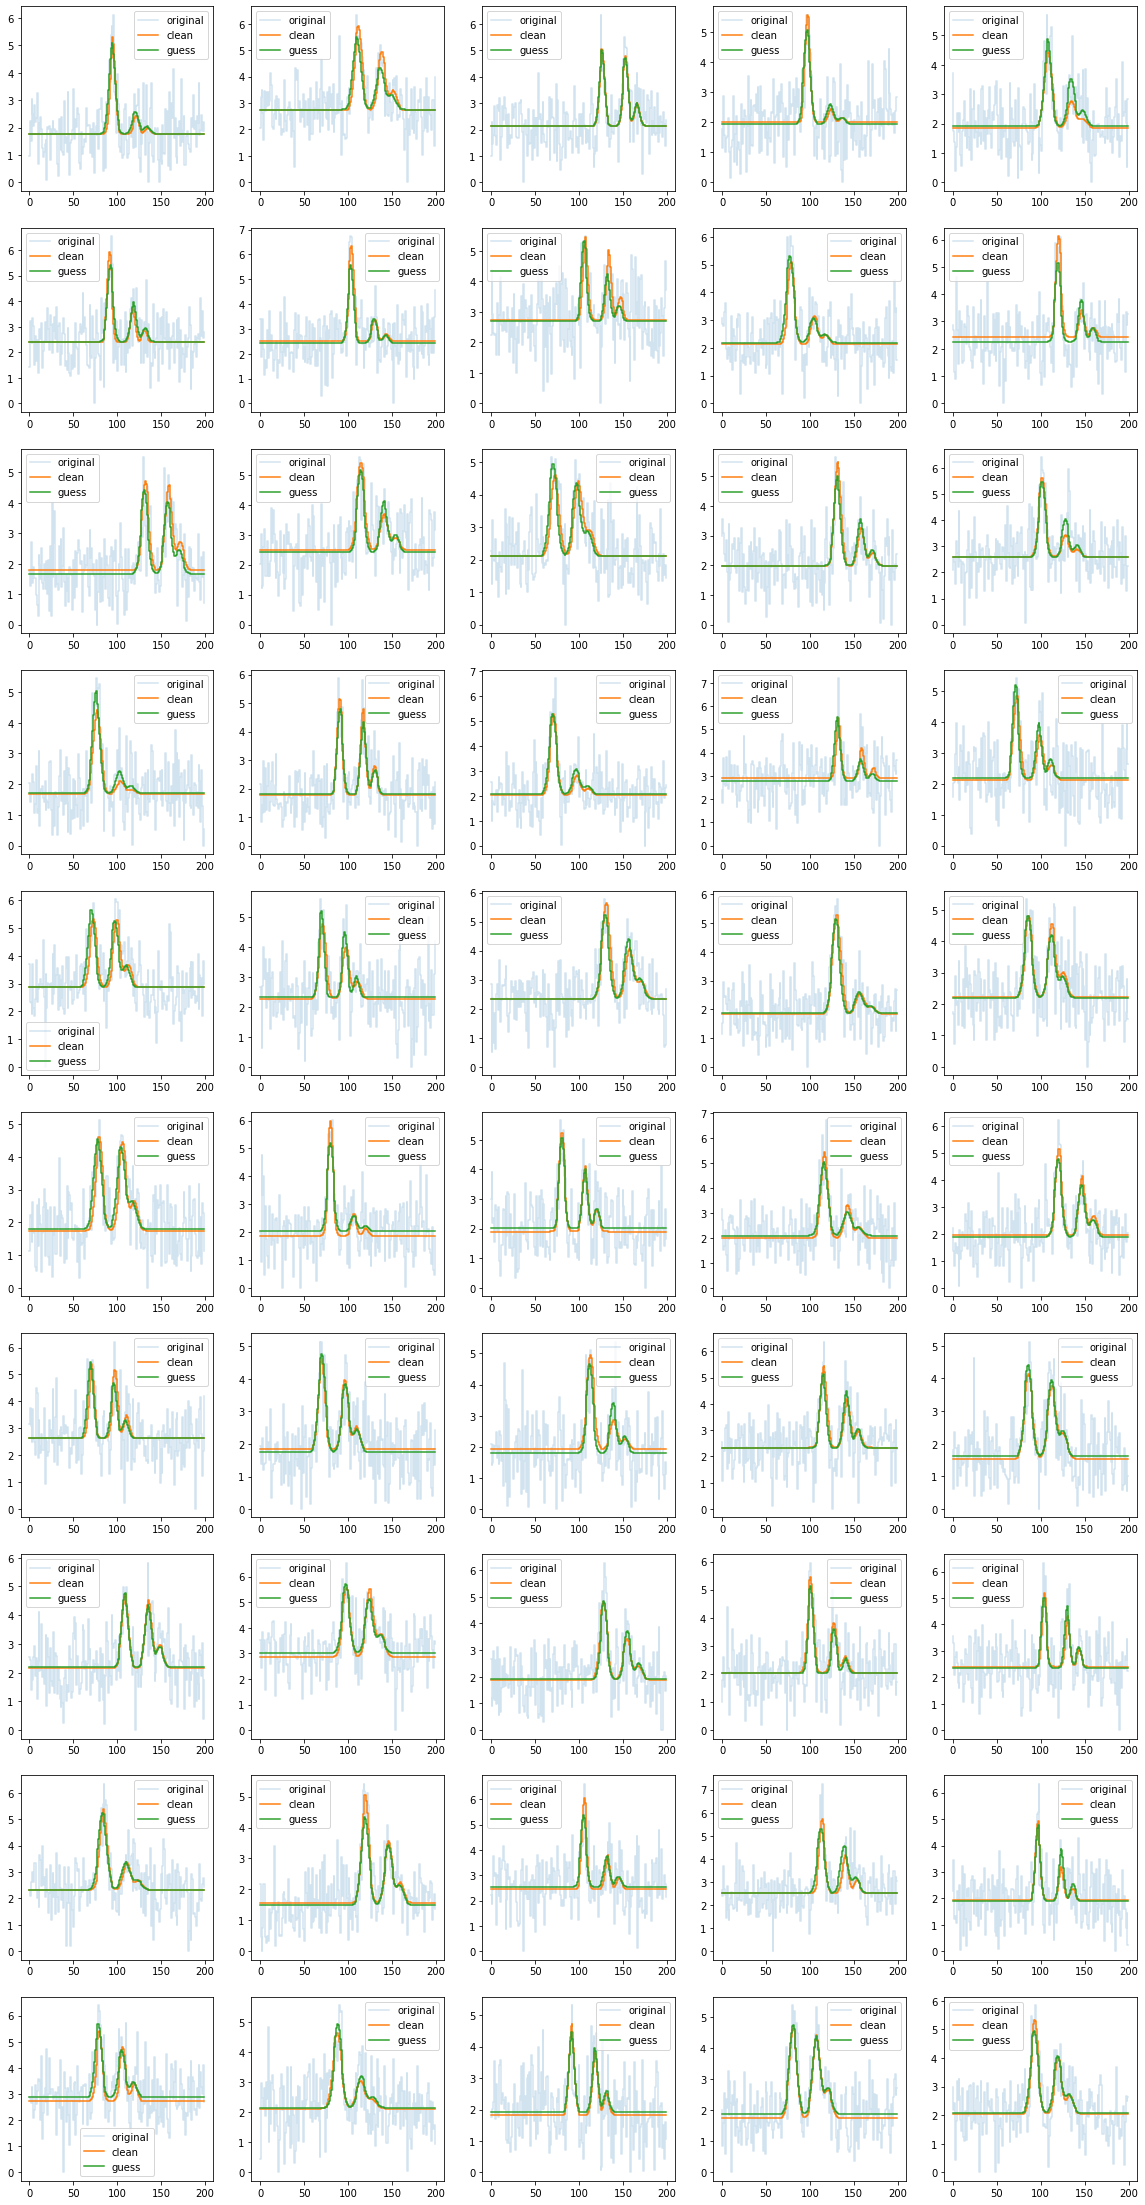

In [277]:
n1 = 5
n2 = 10
plt.figure(figsize=(4*n1,4*n2))
for i in range(n1*n2):
    plt.subplot(n2,n1,i+1)
    plt.plot(ys_test_004_nl4[i],label='original',alpha=0.2,drawstyle='steps-mid')
    plt.plot(ys_test_clean_004_nl4[i],label='clean',drawstyle='steps-mid')
    plt.plot(pred_004_nl4[i],label='guess',drawstyle='steps-mid')
    plt.legend()
plt.show()